In [129]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

from simulations.analysis.plotting_helpers import error_band_plot
from simulations.analysis.plotting_helpers import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
df_ps_dict = load_data(["surface_new", "surface_matching"], prefixes=["", "matching_"])

## pfail vs pabort

In [131]:
from simulations.analysis.plotting_helpers import (
    take_best_by_from_df_ps_dict,
    get_lower_envelope,
    error_band_plot,
)

In [132]:
df_ps_best = take_best_by_from_df_ps_dict(
    df_ps_dict,
    exclude=(lambda by: "matching" in by or by in {"pred_llr", "detector_density"}),
    use_pfail_upper=False,
)

In [133]:
def plot_plog_against_pabort(p, d):
    fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 4.5))

    df_ps_matching_gap_all = df_ps_dict["matching_gap"]

    def plot(df, **kwargs):
        df = df.reset_index()
        p_abort = df["p_abort"].values
        p_fail = df["p_fail"].values / d
        delta_p_fail = df["delta_p_fail"].values / d
        error_band_plot(p_abort, p_fail, delta_p_fail, ax=ax, **kwargs)

    # Best cluster norm
    df_ps_d = df_ps_best.loc[idx[d, d, p, :], :]
    plot(df_ps_d, label=rf"Best cluster-norm", color=COLORS(0))

    # Logical gap
    try:
        df_ps_matching_gap = df_ps_matching_gap_all.loc[idx[d, d, p, :], :]
        df_ps_matching_gap = get_lower_envelope(df_ps_matching_gap)
        plot(
            df_ps_matching_gap,
            label=rf"Logical gap $\Delta$",
            color=COLORS(1),
            linestyle="--",
        )
    except KeyError:
        pass

    # Prediction LLR
    plot(
        df_ps_dict["pred_llr"].loc[idx[d, d, p, :], :],
        label=rf"Weight $w(E)$",
        color=COLORS(2),
        linestyle="-.",
    )

    # Detector density
    plot(
        df_ps_dict["detector_density"].loc[idx[d, d, p, :], :],
        label=rf"Detector density $\sigma_\mathrm{{det}}$",
        color=COLORS(3),
        linestyle=":",
    )

    # ax.set_xscale("log")
    ax.set_title(rf"$d={d}, p={p}$")
    ax.set_xlim(0, 1)
    ax.set_yscale("log")
    ax.legend()
    ax.set_ylim(1e-10, 1)

    ax.set_xlabel(r"Abort rate $p_\mathrm{abort}$")
    ax.set_ylabel(r"Per-round logical error rate $p_\mathrm{log} / T$")

    fig.tight_layout()

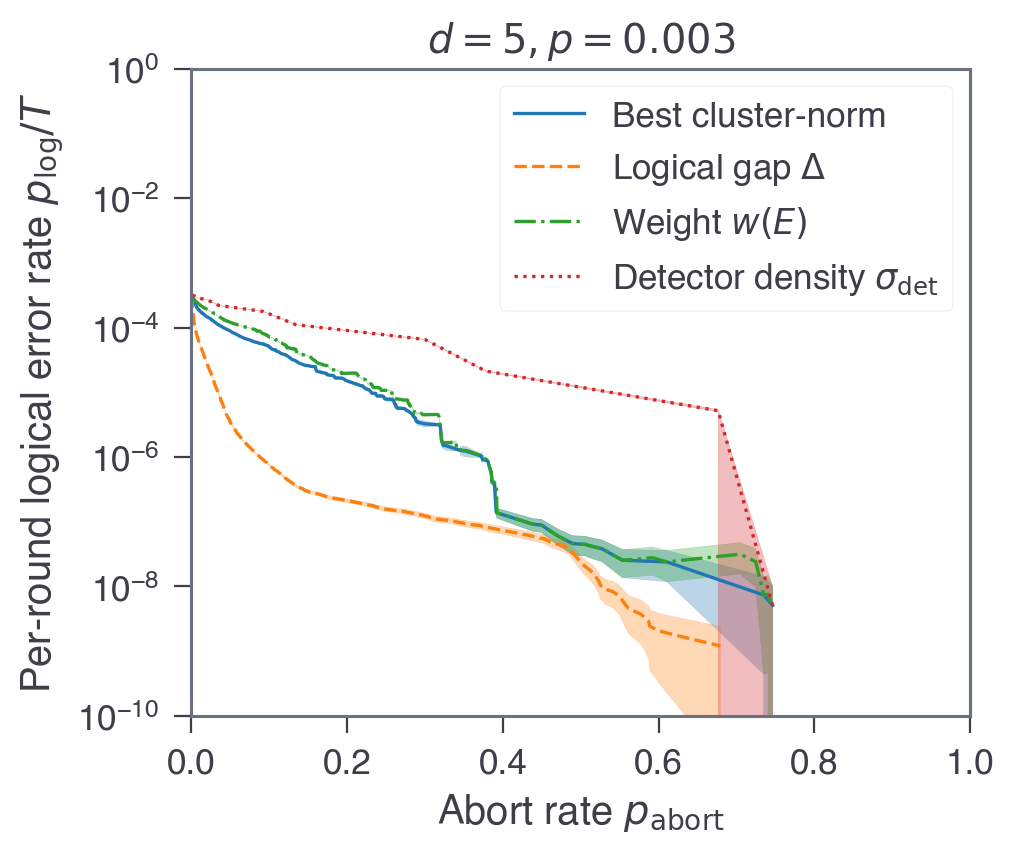

In [142]:
plot_plog_against_pabort(3e-3, 5)

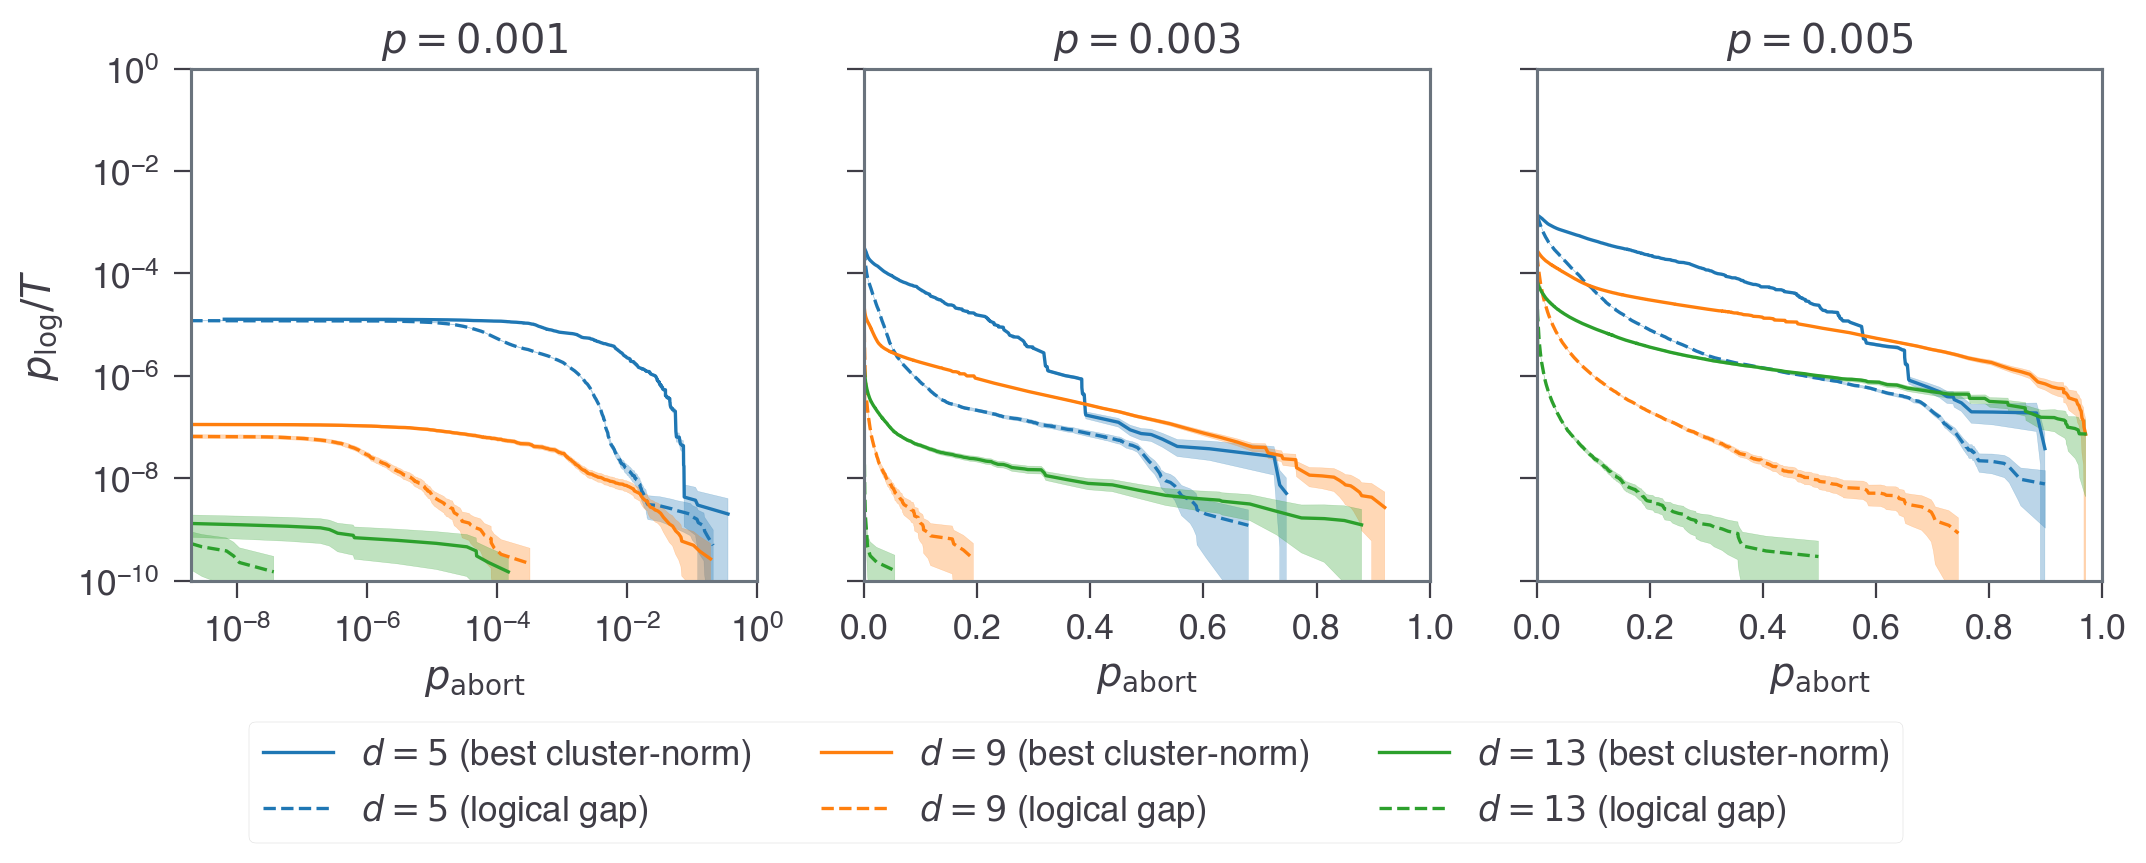

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(DFT_FIG_WIDTH_WIDE, 4), sharey=True)

d_values = [5, 9, 13]
p_values = [0.001, 0.003, 0.005]

dlist = df_ps_best.index.get_level_values("d").unique()
df_ps_matching_gap_all = df_ps_dict["matching_gap"]

# Create legend handles and labels
legend_handles = []
legend_labels = []

for i_p, p in enumerate(p_values):
    ax = axes[i_p]

    for i_d, d in enumerate(d_values):
        df_ps_d = df_ps_best.loc[idx[d, d, p, :], :]
        p_abort = df_ps_d.index.get_level_values("p_abort").values
        p_fail = df_ps_d["p_fail"].values / d
        delta_p_fail = df_ps_d["delta_p_fail"].values / d
        line1 = error_band_plot(
            p_abort,
            p_fail,
            delta_p_fail,
            color=COLORS(i_d),
            label=rf"$d={d}$ (best cluster-norm)",
            ax=ax,
        )

        try:
            df_ps_matching_gap = df_ps_matching_gap_all.loc[idx[d, d, p, :], :]
        except KeyError:
            continue
        df_ps_matching_gap = get_lower_envelope(df_ps_matching_gap)
        p_abort = df_ps_matching_gap["p_abort"].values
        p_fail = df_ps_matching_gap["p_fail"].values / d
        delta_p_fail = df_ps_matching_gap["delta_p_fail"].values / d
        line2 = error_band_plot(
            p_abort,
            p_fail,
            delta_p_fail,
            color=COLORS(i_d),
            label=rf"$d={d}$ (logical gap)",
            linestyle="--",
            ax=ax,
        )

        # Collect legend handles and labels only from the first subplot
        if i_p == 0:
            legend_handles.extend([line1[0], line2[0]])
            legend_labels.extend(
                [rf"$d={d}$ (best cluster-norm)", rf"$d={d}$ (logical gap)"]
            )

    if i_p == 0:
        ax.set_xscale("log")
        ax.set_xlim(2e-9, 1)
        ax.set_xticks([1e-8, 1e-6, 1e-4, 1e-2, 1e0])
    else:
        ax.set_xlim(0, 1)
    ax.set_yscale("log")
    ax.set_ylim(1e-10, 1)
    ax.set_xlabel(r"$p_\mathrm{abort}$")
    ax.set_title(f"$p = {p}$")

    if i_p == 0:
        ax.set_ylabel(r"$p_\mathrm{log} / T$")

# Add legend below the figure with 3 columns
fig.legend(
    legend_handles,
    legend_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
)

fig.tight_layout()
plt.subplots_adjust(bottom=0.25)

logical error rate vs spacetime cost (code distance & abort rate) at a physical error rate
or vs footprint (space cost)

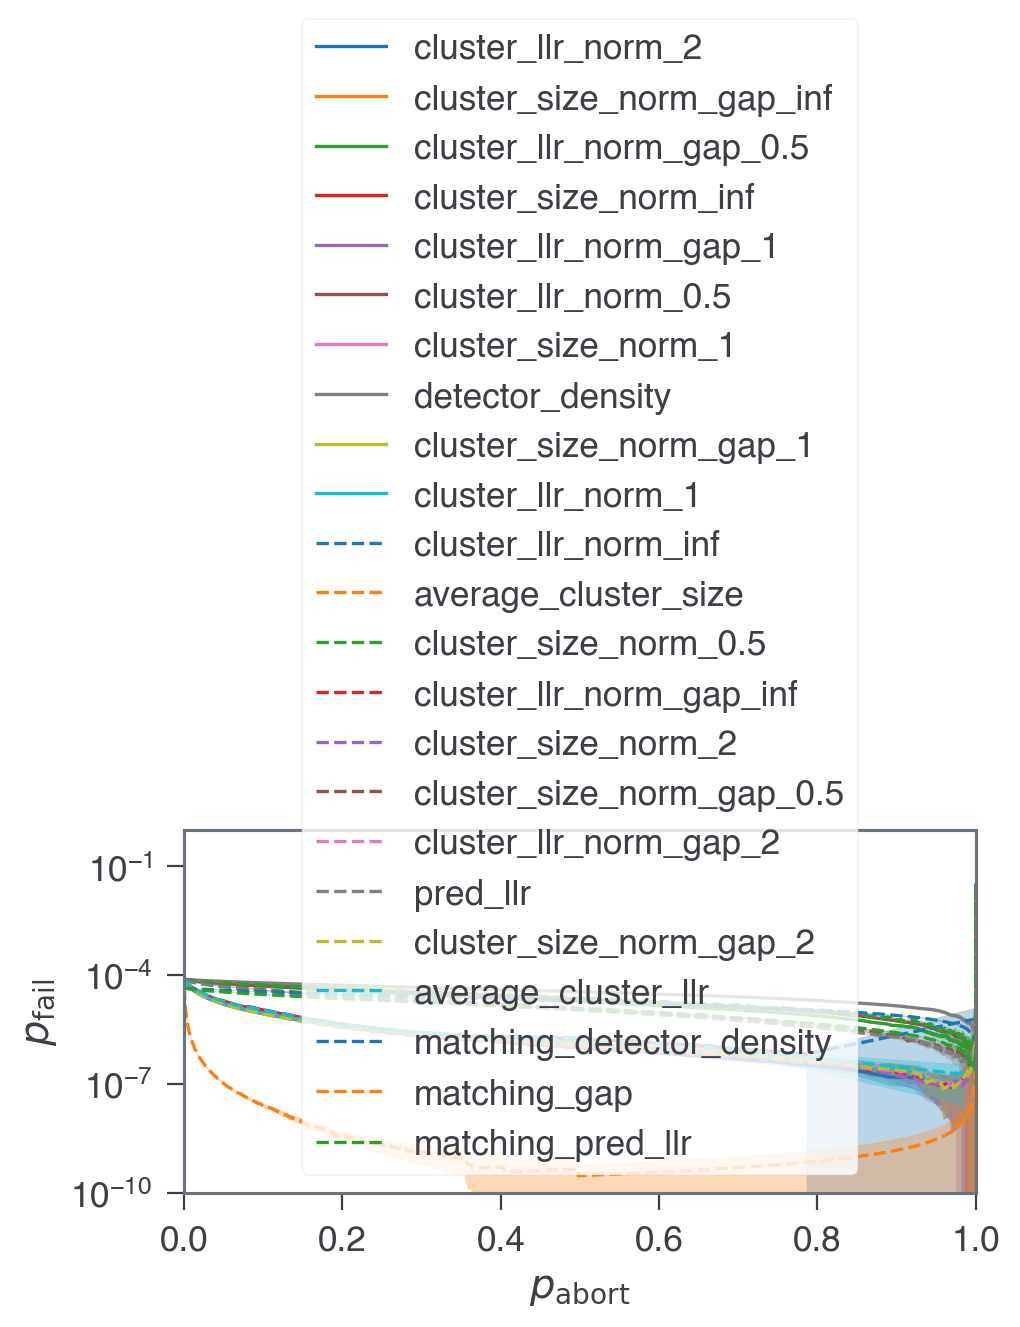

In [7]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 5))

d = T = 13
p = 5e-3

# Create ordered list of keys
ordered_keys = df_ps_dict.keys()

# # First, add cluster_llr_norm_gap keys in ascending order of i (as float)
# cluster_keys = [key for key in df_ps_dict.keys() if "cluster_llr_norm_gap" in key]
# # Sort by extracting the number after 'cluster_llr_norm_gap_' as float
# cluster_keys.sort(
#     key=lambda x: (
#         float(x.split("_")[-1])
#         if x.split("_")[-1].replace(".", "").isdigit()
#         else float("inf")
#     )
# )
# ordered_keys.extend(cluster_keys)

# ordered_keys.extend(["average_cluster_size", "average_cluster_llr"])

# Then add the other keys in specified order
# for key in ["matching_gap", "pred_llr", "detector_density"]:
#     if key in df_ps_dict:
#         ordered_keys.append(key)


i = 0
data_plots = {}
for by in ordered_keys:
    df_ps_all = df_ps_dict[by]
    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    try:
        df_ps = df_ps_all.loc[idx[d, T, p, :], :]
    except KeyError:
        continue

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values / T
    delta_p_fail = df_ps[delta_p_fail_col].values / T
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i % 10),
        linestyle="-" if i < 10 else "--",
        label=by,
        ax=ax,
    )
    i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()

relation to BP convergence

0: matching_gap (1.31e-09 ± 7.13e-10)
1: cluster_llr_norm_gap_inf (2.09e-06 ± 9.38e-08)
2: cluster_llr_norm_gap_2 (2.14e-06 ± 9.48e-08)
3: cluster_size_norm_2 (2.24e-06 ± 9.72e-08)
4: cluster_llr_norm_2 (2.26e-06 ± 9.74e-08)
5: cluster_size_norm_gap_inf (2.34e-06 ± 9.92e-08)
6: cluster_size_norm_gap_2 (2.38e-06 ± 1.00e-07)
7: cluster_llr_norm_gap_1 (2.53e-06 ± 1.03e-07)
8: cluster_llr_norm_1 (2.53e-06 ± 1.03e-07)
9: cluster_llr_norm_inf (2.53e-06 ± 1.03e-07)
10: cluster_size_norm_gap_1 (2.55e-06 ± 1.04e-07)
11: cluster_size_norm_inf (2.77e-06 ± 1.07e-07)
12: cluster_size_norm_1 (2.96e-06 ± 1.10e-07)
13: pred_llr (1.93e-05 ± 2.86e-07)
14: cluster_size_norm_gap_0.5 (2.10e-05 ± 2.98e-07)
15: cluster_llr_norm_gap_0.5 (2.96e-05 ± 3.53e-07)
16: cluster_llr_norm_0.5 (3.32e-05 ± 3.74e-07)
17: cluster_size_norm_0.5 (3.45e-05 ± 3.81e-07)
18: detector_density (4.64e-05 ± 4.38e-07)


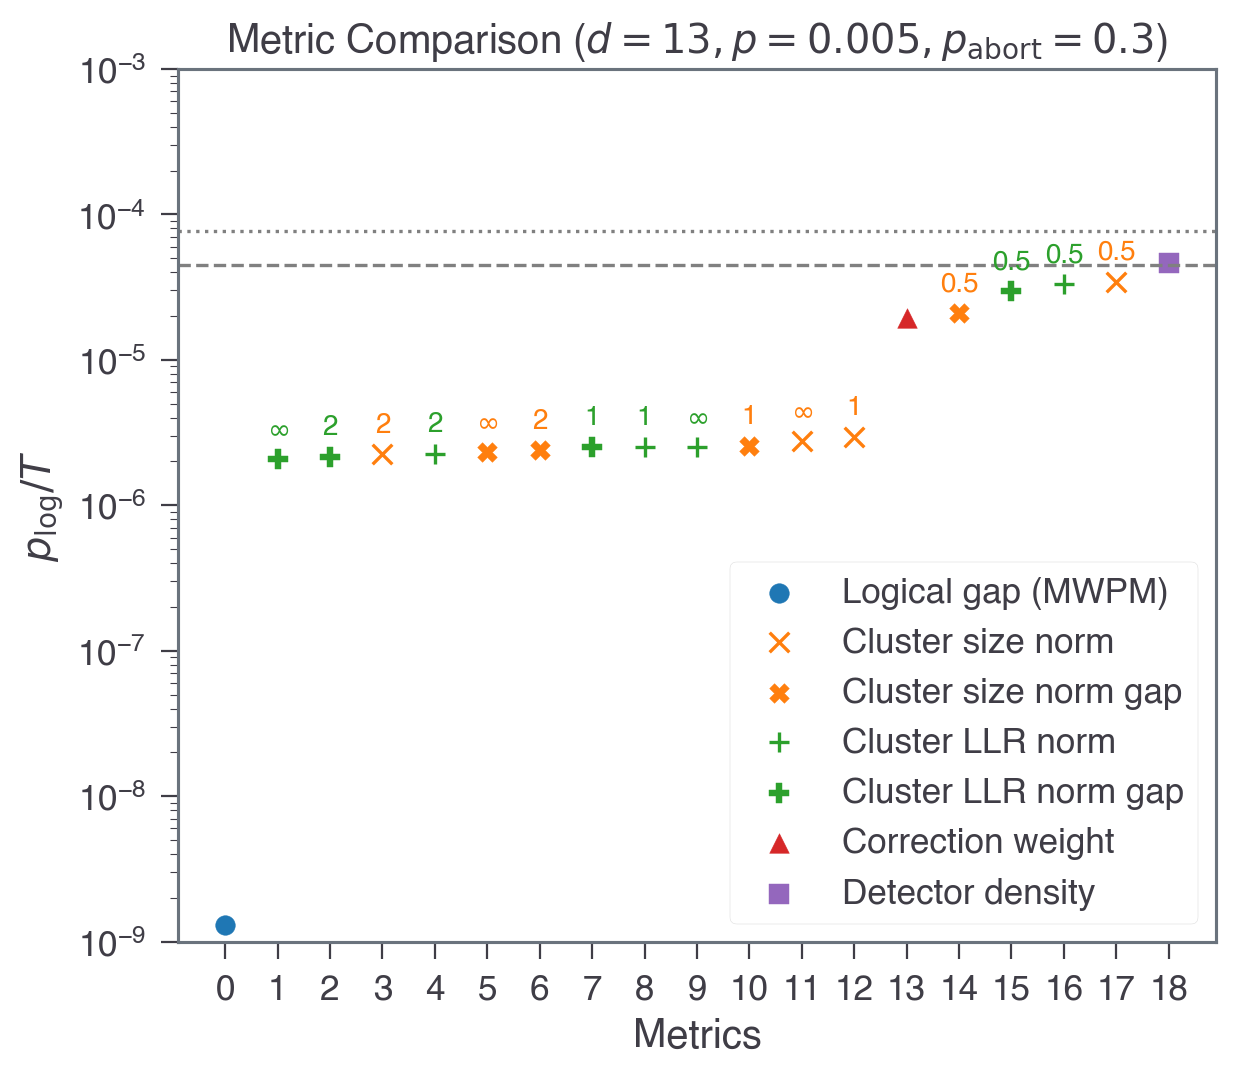

In [13]:
target = 0.3
bys, y_vals, y_errs = [], [], []

by_to_exclude = [
    "average_cluster_size",
    "average_cluster_llr",
    "matching_pred_llr",
    "matching_detector_density",
]

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    if by in by_to_exclude:
        continue
    ind = np.where(p_abort <= target)[0]
    if len(ind):
        sel = ind[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")


def determine_group(by):
    if "matching" in by:
        group = 0
        color = COLORS(0)
        label = "Logical gap (MWPM)"
        marker = "o"
    elif "cluster_size_norm" in by:
        if "gap" in by:
            group = 2
            label = "Cluster size norm gap"
            marker = "X"
        else:
            group = 1
            label = "Cluster size norm"
            marker = "x"
        color = COLORS(1)
    elif "cluster_llr_norm" in by:
        if "gap" in by:
            group = 4
            label = "Cluster LLR norm gap"
            marker = "P"
        else:
            group = 3
            label = "Cluster LLR norm"
            marker = "+"
        color = COLORS(2)
    elif by == "pred_llr":
        group = 5
        label = "Correction weight"
        marker = "^"
        color = COLORS(3)
    elif by == "detector_density":
        group = 6
        label = "Detector density"
        marker = "s"
        color = COLORS(4)
    else:
        group = 7
        label = "other"
        marker = "s"
        color = COLORS(5)
    return group, label, marker, color


# Group data and plot with different colors
group_labels_added = set()
legend_handles = []
legend_labels = []

for i, by in enumerate(by_sorted):
    group, group_label, marker, color = determine_group(by)
    label = group_label if group_label not in group_labels_added else None

    handle = plt.scatter(
        i,
        y_vals_sorted[i],
        marker=marker,
        s=50,
        color=color,
        label=label,
    )

    # Add number annotation for "norm" metrics
    if "norm" in by:
        norm_order = by.split("_")[-1]
        if norm_order == "inf":
            norm_order = r"$\infty$"

        plt.text(
            i,
            y_vals_sorted[i] * 1.3,  # Position slightly above the marker
            norm_order,
            ha="center",
            va="bottom",
            fontsize=10,
            color=color,
        )

    if label:
        group_labels_added.add(group_label)
        legend_handles.append((group, handle))
        legend_labels.append((group, group_label))

pfail_org = (
    df_ps_dict["cluster_llr_norm_1"].loc[idx[d, d, p, :], "p_fail"].values[-1] / T
)
pfail_org_matching = (
    df_ps_dict["matching_gap"].loc[idx[d, d, p, :], "p_fail"].values[0] / T
)

plt.axhline(pfail_org, color="grey", linestyle=":", label="BP+LSD")
plt.axhline(pfail_org_matching, color="grey", linestyle="--", label="MWPM")


# Sort legend by group order
legend_handles.sort(key=lambda x: x[0])
legend_labels.sort(key=lambda x: x[0])

plt.title(rf"Metric Comparison ($d = {d}, p = {p}, p_\mathrm{{abort}} = {target}$)")
plt.xticks(np.arange(len(by_sorted)), np.arange(len(by_sorted)))
plt.xlabel("Metrics")
plt.ylabel(r"$p_{\mathrm{log}} / T$")
plt.yscale("log")
plt.ylim(1e-9, 1e-3)
plt.legend(
    [h[1] for h in legend_handles], [l[1] for l in legend_labels], loc="lower right"
)
plt.tight_layout()
plt.show()

## Abort rate to achieve a certain logical error rate reduction

In [44]:
df_ps = df_ps_dict["cluster_llr_norm_gap_2"]
df_ps.head()

p_fail  delta_p_fail   p_abort  \
d T p     cluster_llr_norm_gap                                     
5 5 0.001 1624.142835           0.000084      0.000018  0.000002   
          1629.096792           0.000084      0.000018  0.000003   
          1696.156444           0.000084      0.000018  0.000004   
          1696.357824           0.000084      0.000018  0.000005   
          1696.680033           0.000084      0.000018  0.000006   

                                delta_p_abort    count  num_fails  \
d T p     cluster_llr_norm_gap                                      
5 5 0.001 1624.142835                0.000002  1000000         82   
          1629.096792                0.000003   999999         82   
          1696.156444                0.000003   999998         82   
          1696.357824                0.000004   999997         82   
          1696.680033                0.000004   999996         82   

                                p_fail_conv  delta_p_fail_conv  p_abort_conv  \
d T p     cluster_llr_norm_gap                                                 
5 5 0.001 1624.142835              0.000084           0.000018      0.000002   
          1629.096792              0.000084           0.000018      0.000003   
          1696.156444              0.000084           0.000018      0.000004   
          1696.357824              0.000084           0.000018      0.000005   
          1696.680033              0.000084           0.000018      0.000006   

                                delta_p_abort_conv  count_conv  num_fails_conv  
d T p     cluster_llr_norm_gap                                                  
5 5 0.001 1624.142835                     0.000002     1000000              82  
          1629.096792                     0.000003      999999              82  
          1696.156444                     0.000003      999998              82  
          1696.357824                     0.000004      999997              82  
          1696.680033                     0.000004      999996              82

In [45]:
df_org = (
    df_ps.groupby(level=[0, 2])
    .apply(lambda group: group.loc[group["p_abort"].idxmin(), "p_fail"])
    .to_frame(name="p_fail")
)
df_org.head()

p_fail
d p              
5 0.001  0.000084
  0.002  0.000475
  0.003  0.001639
  0.004  0.003763
  0.005  0.007063

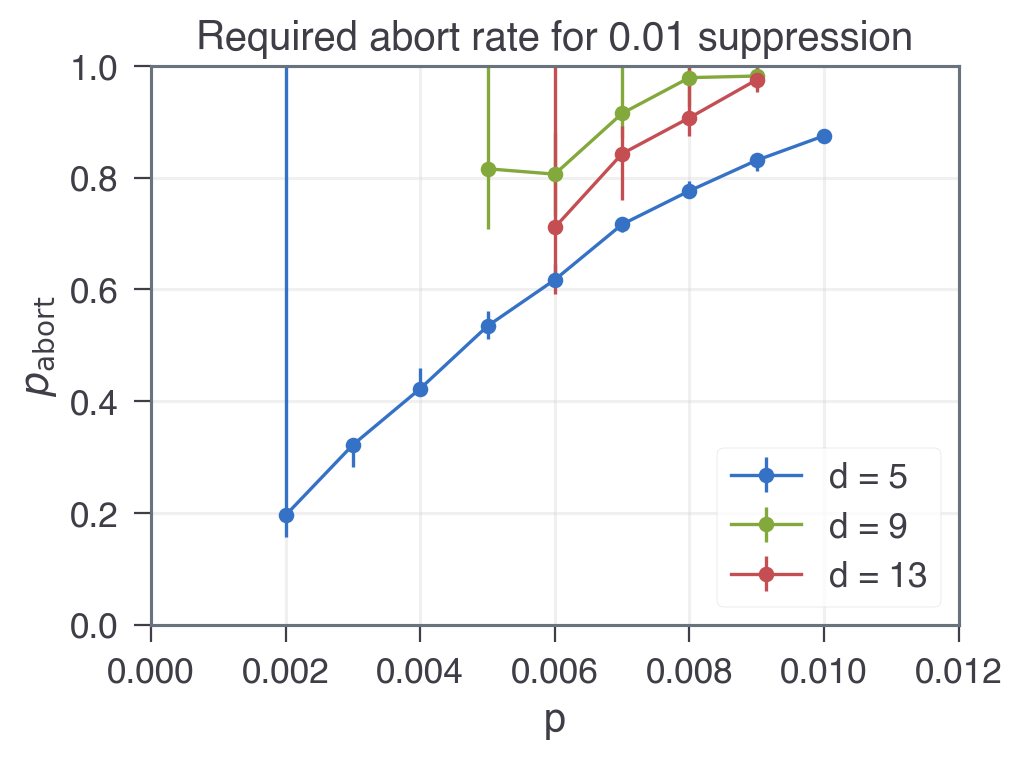

In [51]:
plist = df_org.index.get_level_values("p").unique()

target_suppression = 1e-2
results = []

for d in [5, 9, 13]:
    for p in plist:
        df_ps_dp = df_ps.loc[(d, d, p)]
        p_fail_org = df_org.loc[(d, p), "p_fail"]

        # Calculate target threshold
        target_threshold = p_fail_org * target_suppression

        # Find p_abort using central p_fail estimate
        valid_rows = df_ps_dp[df_ps_dp["p_fail"] < target_threshold]
        p_abort = valid_rows["p_abort"].min() if not valid_rows.empty else np.nan

        # Calculate error bounds for p_abort
        # Use p_fail - delta_p_fail for lower bound (more conservative threshold)
        p_fail_lower = df_ps_dp["p_fail"] - df_ps_dp["delta_p_fail"]
        valid_rows_lower = df_ps_dp[p_fail_lower < target_threshold]
        p_abort_lb = (
            valid_rows_lower["p_abort"].min() if not valid_rows_lower.empty else 0.0
        )

        # Use p_fail + delta_p_fail for upper bound (less conservative threshold)
        p_fail_upper = df_ps_dp["p_fail"] + df_ps_dp["delta_p_fail"]
        valid_rows_upper = df_ps_dp[p_fail_upper < target_threshold]
        p_abort_ub = (
            valid_rows_upper["p_abort"].min() if not valid_rows_upper.empty else 1.0
        )

        # Calculate asymmetric error bars
        delta_p_abort_lower = p_abort - p_abort_lb
        delta_p_abort_upper = p_abort_ub - p_abort

        results.append(
            {
                "d": d,
                "p": p,
                "p_abort": p_abort,
                "delta_p_abort_lower": delta_p_abort_lower,
                "delta_p_abort_upper": delta_p_abort_upper,
            }
        )

# Convert results to DataFrame for plotting
results_df = pd.DataFrame(results)

# Plot p vs p_abort for each d
plt.figure(figsize=(DFT_FIG_WIDTH, 4))

for d in dlist:
    d_data = results_df[results_df["d"] == d]
    if not d_data.empty:
        plt.errorbar(
            d_data["p"],
            d_data["p_abort"],
            yerr=[
                d_data["delta_p_abort_lower"],
                d_data["delta_p_abort_upper"],
            ],
            marker="o",
            label=f"d = {d}",
            capsize=3,
        )

plt.xlabel("p")
plt.ylabel(r"$p_\mathrm{abort}$")
plt.title(f"Required abort rate for {target_suppression} suppression")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1.2e-2)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

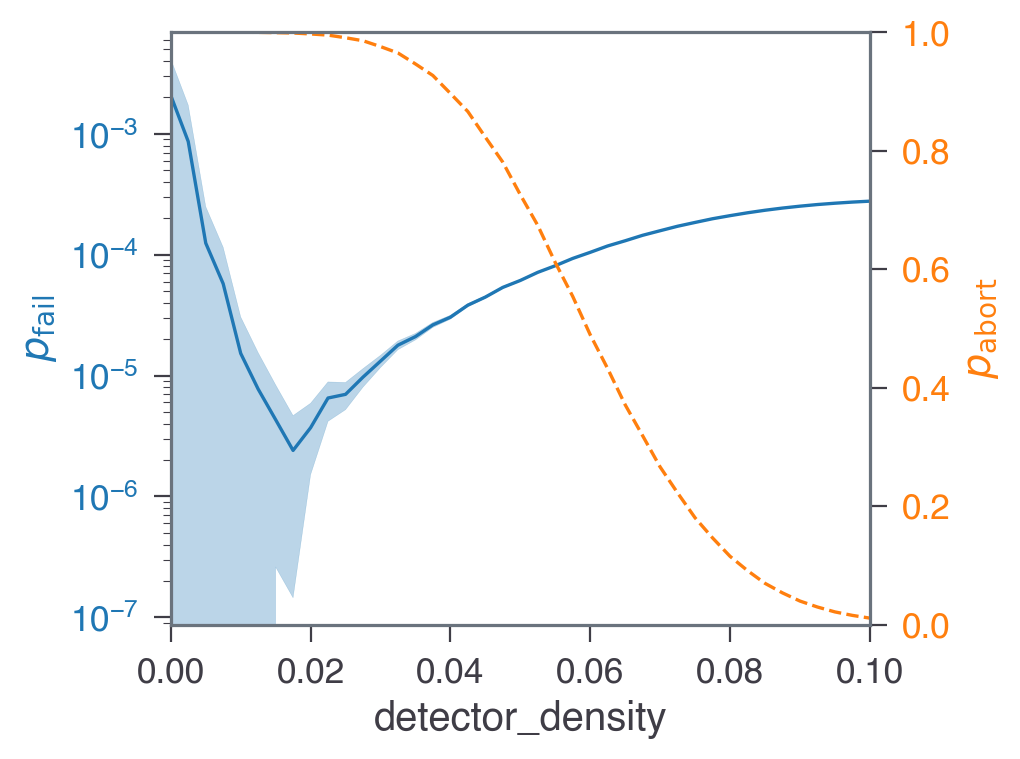

In [115]:
d = T = 9
p = 0.005
by = "detector_density"

df_ps = df_ps_dict[by].loc[idx[d, T, p, :], :]

x_vals = df_ps.index.get_level_values(3).values
p_fail = df_ps["p_fail"].values / T
delta_p_fail = df_ps["delta_p_fail"].values / T
p_abort = df_ps["p_abort"].values

fig, ax1 = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

color1 = COLORS(0)
color2 = COLORS(1)

# ax1.plot(x_vals, p_fail, color=color1, label="p_fail")
error_band_plot(x_vals, p_fail, delta_p_fail, ax=ax1, color=color1)
ax1.set_ylabel(r"$p_\mathrm{fail}$", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.set_xlabel(by)
ax1.set_yscale("log")
ax1.set_xlim(0, 0.1)

ax2 = ax1.twinx()
ax2.plot(x_vals, p_abort, color=color2, label="p_abort", linestyle="--")
ax2.set_ylabel(r"$p_\mathrm{abort}$", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)
# ax2.set_yscale("log")
ax2.set_ylim(0, 1)

fig.tight_layout()

## pfail vs p for a fixed abort rate

In [11]:
from ldpc.codes import ring_code
from bposd.hgp import hgp

h1 = ring_code(5)
h2 = ring_code(5)

qcode = hgp(h1, h2, compute_distance=True)

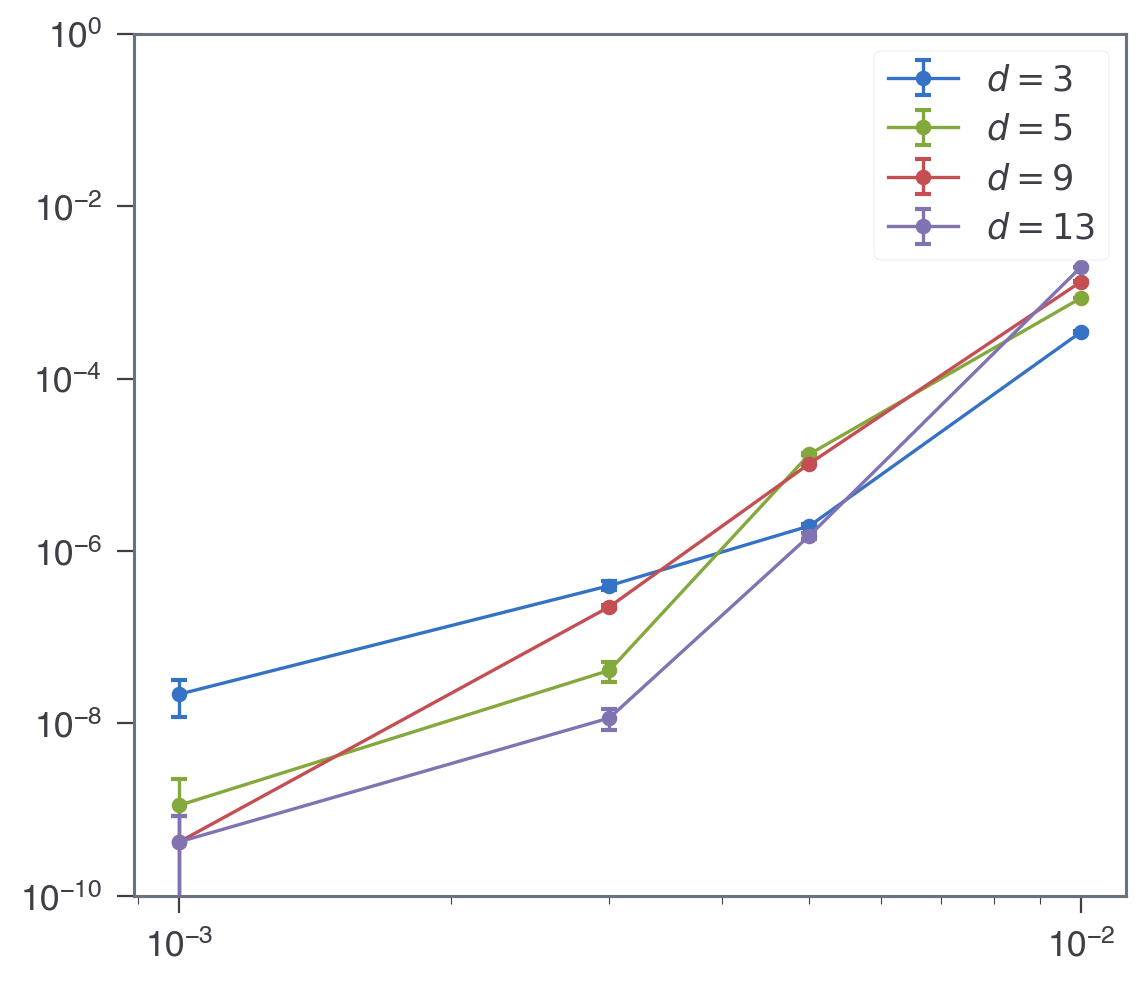

In [254]:
by = "cluster_llr_norm_gap_2"
# by = 'matching_gap'
target_p_abort = 0.5

df_ps = df_ps_dict[by]
dlist = df_ps.index.get_level_values("d").unique()
for i_d, d in enumerate(dlist):
    df_ps_d = df_ps.loc[idx[d, d, :, :], :]
    plist = df_ps_d.index.get_level_values("p").unique()
    pfails = []
    delta_pfails = []
    for i_p, p in enumerate(plist):
        df_ps_dp = df_ps_d.loc[idx[d, d, p, :], :]
        inds = np.where(df_ps_dp["p_abort"] <= target_p_abort)[0]
        if len(inds):
            ind = inds[-1]
        else:
            ind = 0
        pfail = df_ps_dp.iloc[ind]["p_fail"] / T
        delta_pfail = df_ps_dp.iloc[ind]["delta_p_fail"] / T
        pfails.append(pfail)
        delta_pfails.append(delta_pfail)

    plt.errorbar(
        plist,
        pfails,
        yerr=delta_pfails,
        label=f"$d={d}$",
        marker="o",
        capsize=3,  # Add caps (heads) to the error bars
        capthick=1.5,  # Make the cap (head) lines thicker for visibility
    )

plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-10, 1)
plt.legend()

## pfail vs d for a fixed abort rate

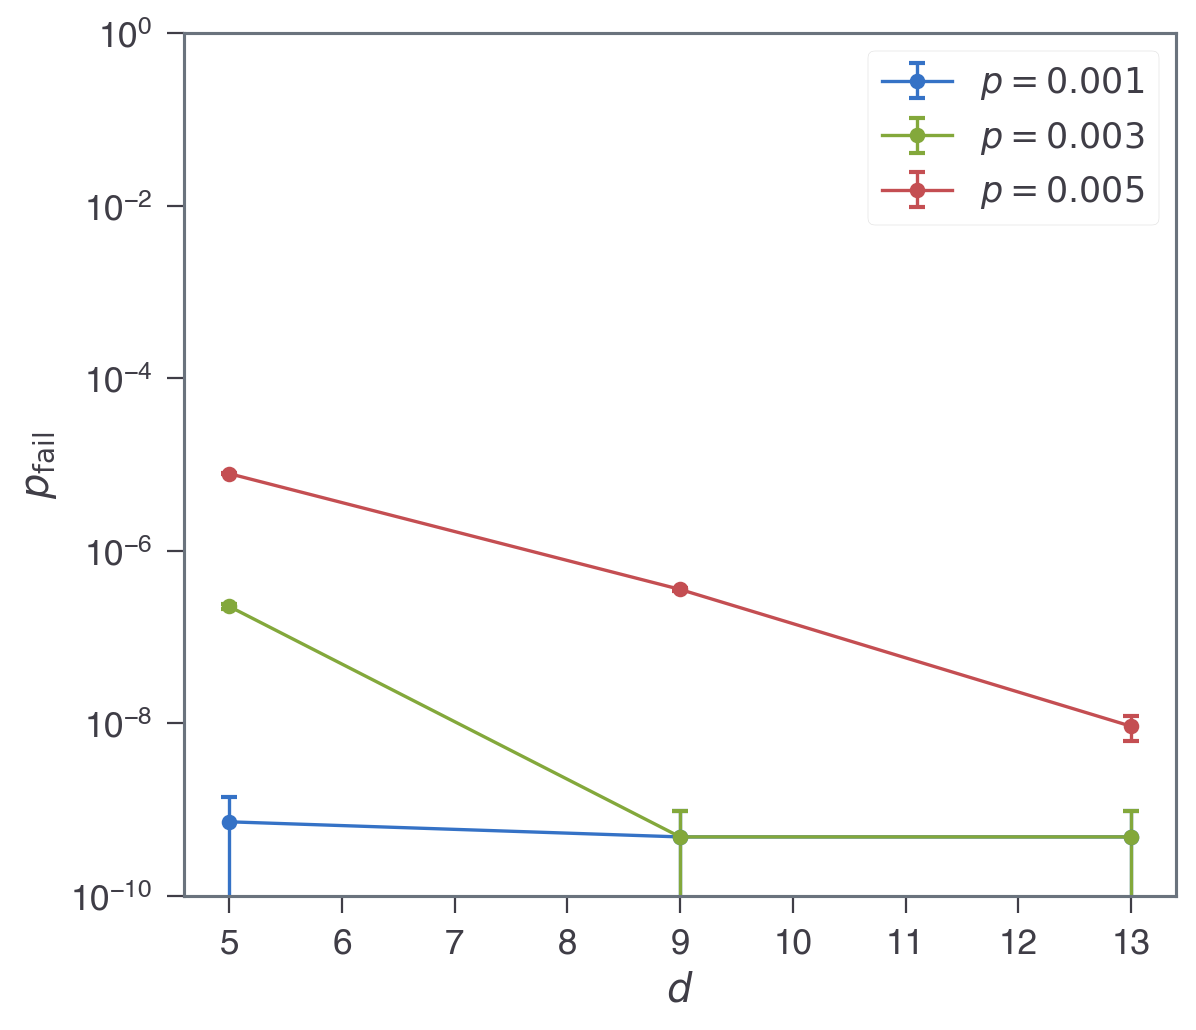

In [104]:
by = "matching_gap"
target_p_abort = 0.2

df_ps = df_ps_dict[by]
plist = df_ps.index.get_level_values("p").unique()
dlist = df_ps.index.get_level_values("d").unique()

for i_p, p in enumerate(plist):
    pfails = []
    delta_pfails = []
    for i_d, d in enumerate(dlist):
        df_ps_d = df_ps.loc[idx[d, d, p, :], :]
        inds = np.where(df_ps_d["p_abort"] <= target_p_abort)[0]
        if len(inds):
            ind = inds[-1]
        else:
            ind = 0
        pfail = df_ps_d.iloc[ind]["p_fail"] / T
        delta_pfail = df_ps_d.iloc[ind]["delta_p_fail"] / T
        pfails.append(pfail)
        delta_pfails.append(delta_pfail)

    plt.errorbar(
        dlist,
        pfails,
        yerr=delta_pfails,
        label=f"$p={p}$",
        marker="o",
        capsize=3,  # Add caps (heads) to the error bars
        capthick=1.5,  # Make the cap (head) lines thicker for visibility
    )

plt.yscale("log")
plt.ylim(1e-10, 1)
plt.xlabel("$d$")
plt.ylabel("$p_{\\mathrm{fail}}$")
plt.legend()

## Cluster norm distribution

In [14]:
df_agg_dict = load_data(
    ["surface", "surface_matching"], "agg", prefixes=["", "matching_"]
)

Text(0.5, 0, 'Cluster LLR norm gap (order = $\\infty$)')

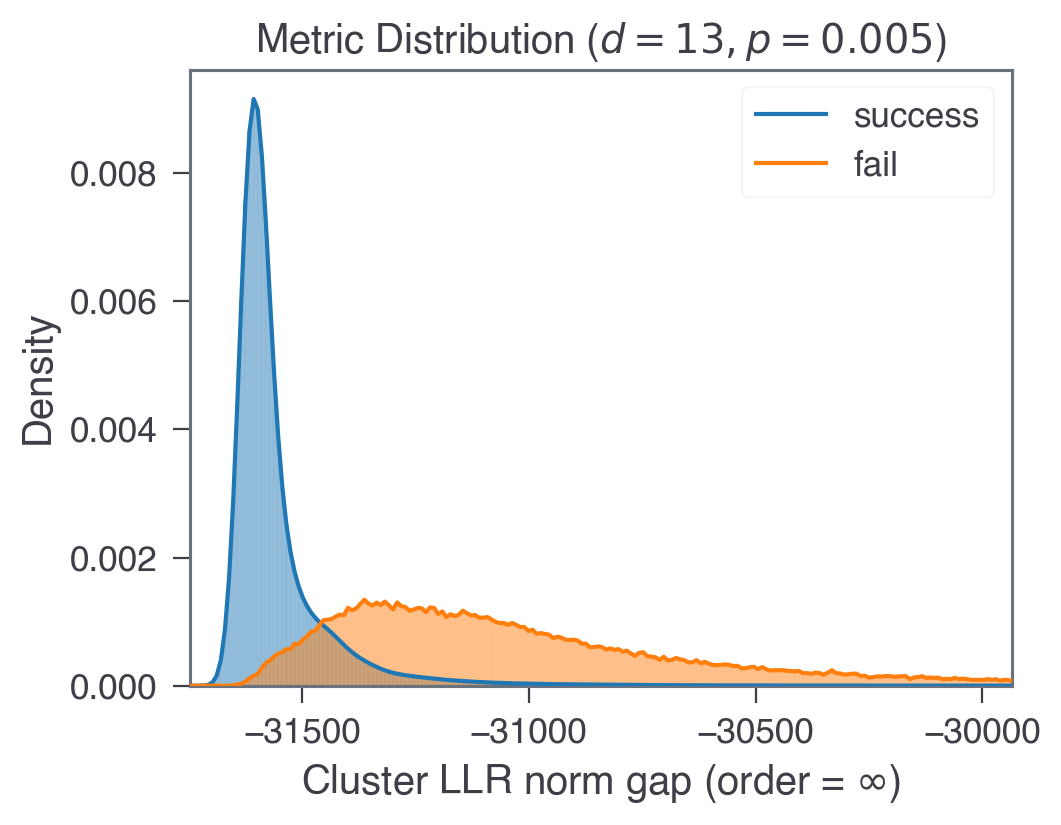

In [21]:
import matplotlib.pyplot as plt
from simulations.analysis.plotting_helpers import plot_success_failure_histogram

# by = "cluster_llr_norm_gap_1"
by = "cluster_llr_norm_gap_inf"
d = T = 13
p = 5e-3

df_agg = df_agg_dict[by].loc[(d, T, p)]
df_agg_plot = df_agg.copy()
df_agg_plot.index = -df_agg_plot.index

fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

plot_success_failure_histogram(
    df_agg_plot,
    bins=1000,
    colors=[COLORS(0), COLORS(1)],
    # rescale_by_rate=True,
    # twin_y=True,
    alpha=0.5,
    ax=ax,
    upper_trim_frac=5e-2,
)

ax.set_title(rf"Metric Distribution ($d = {d}, p = {p}$)")
ax.set_xlabel(r"Cluster LLR norm gap (order = $\infty$)")

### Discrimination power

In [87]:
# With aggregated data

from simulations.analysis.plotting_helpers import (
    calculate_discrimination_metrics_from_agg,
)

d = T = 9
p = 5e-3
for by in ["cluster_llr_norm", "cluster_llr_norm_gap"]:
    for norm_order in [0.5, 1, 2, "inf"]:
        by_name = f"{by}_{norm_order}"
        ascending_confidence = True if "gap" in by_name else False

        df_agg = df_agg_dict[by_name].loc[(d, T, p)]
        df_agg["num_succs"] = df_agg["count"] - df_agg["num_fails"]

        auprc_lift = calculate_discrimination_metrics_from_agg(
            metric_values=df_agg.index.values,
            counts=df_agg["count"],
            num_fails=df_agg["num_fails"],
            method="lift",
            ascending_confidence=ascending_confidence,
        )
        print(f"{by_name}: {auprc_lift}")

cluster_llr_norm_0.5: 6.3127126949764
cluster_llr_norm_1: 25.021235866613775
cluster_llr_norm_2: 21.579863260749274
cluster_llr_norm_inf: 20.3559156377191
cluster_llr_norm_gap_0.5: 8.22328092228908
cluster_llr_norm_gap_1: 25.021234558887592
cluster_llr_norm_gap_2: 23.517509632593157
cluster_llr_norm_gap_inf: 22.99702144513394


In [138]:
# With raw data
from simulations.analysis.data_aggregation import extract_sample_metric_values

data_dir = f"../../data/surface_code_minsum_iter30_lsd0/d{d}_T{T}_p{p}"
metric_values = extract_sample_metric_values(
    data_dir=data_dir, by=by, norm_order=norm_order, dtype="float32"
)
fails = extract_sample_metric_values(
    data_dir=data_dir,
    by="fail",
    dtype="bool",
)

Extracting fail values: 100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


In [140]:
from simulations.analysis.plotting_helpers import (
    calculate_discrimination_metrics_from_raw,
)

calculate_discrimination_metrics_from_raw(
    metric_values=metric_values,
    fails=fails,
    method="auprc",
    ascending_confidence=True,
)

0.0623134526851848

In [91]:
list(df_agg_dict.keys())

['cluster_llr_norm_2',
 'cluster_size_norm_gap_inf',
 'cluster_llr_norm_gap_0.5',
 'cluster_size_norm_inf',
 'cluster_llr_norm_gap_1',
 'cluster_llr_norm_0.5',
 'cluster_size_norm_1',
 'detector_density',
 'cluster_size_norm_gap_1',
 'cluster_llr_norm_1',
 'cluster_llr_norm_inf',
 'average_cluster_size',
 'cluster_size_norm_0.5',
 'cluster_llr_norm_gap_inf',
 'cluster_size_norm_2',
 'cluster_size_norm_gap_0.5',
 'cluster_llr_norm_gap_2',
 'pred_llr',
 'cluster_size_norm_gap_2',
 'average_cluster_llr',
 'matching_detector_density',
 'matching_gap',
 'matching_pred_llr']

In [92]:
# Find the point where cumulative count reaches "fraction" of total count
df_agg = df_agg_dict["cluster_llr_norm_2"]
total_count = df_agg["count"].sum()
cumsum = df_agg["count"].cumsum()
fraction = 1e-4
threshold_count = total_count * fraction
min_index = df_agg.index[cumsum >= threshold_count].min()
bin_range = (min_index, df_agg.index.max())
bins = 100

by_name = df_agg.index.name

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_succs",
    bins=bins,
    stat="density",
    binrange=bin_range,
    alpha=0.4,
    color=COLORS(0),
)

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_succs",
    bins=bins,
    stat="density",
    binrange=bin_range,
    fill=False,
    label="success",
    color=COLORS(0),
    element="poly",
    linewidth=1.5,
)

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_fails",
    bins=bins,
    stat="density",
    binrange=bin_range,
    alpha=0.4,
    color=COLORS(1),
)

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_fails",
    bins=bins,
    stat="density",
    binrange=bin_range,
    fill=False,
    label="fail",
    color=COLORS(1),
    element="poly",
    linewidth=1.5,
)
plt.legend()
plt.xlabel(by)

ValueError: The following variable cannot be assigned with wide-form data: `weights`

## Phenomenological noise

In [117]:
df_ps_dict_phenom = load_data(["surface_phenom"])

In [109]:
print(list(df_ps_dict_phenom.keys()))

['detector_density', 'cluster_llr_norm_gap_2', 'pred_llr']


In [112]:
df_ps_dict_phenom["cluster_llr_norm_gap_2"].head()

p_fail  delta_p_fail   p_abort  \
d  T  p     cluster_llr_norm_gap                                     
13 13 0.015 12843.097560          0.000208      0.000028  0.000002   
            12866.084788          0.000208      0.000028  0.000003   
            12871.401562          0.000208      0.000028  0.000004   
            12891.730403          0.000208      0.000028  0.000005   
            12928.791444          0.000208      0.000028  0.000006   

                                  delta_p_abort    count  num_fails  \
d  T  p     cluster_llr_norm_gap                                      
13 13 0.015 12843.097560               0.000002  1000000        206   
            12866.084788               0.000003   999999        206   
            12871.401562               0.000003   999998        206   
            12891.730403               0.000004   999997        206   
            12928.791444               0.000004   999996        206   

                                  p_fail_conv  delta_p_fail_conv  \
d  T  p     cluster_llr_norm_gap                                   
13 13 0.015 12843.097560             0.000208           0.000028   
            12866.084788             0.000208           0.000028   
            12871.401562             0.000208           0.000028   
            12891.730403             0.000208           0.000028   
            12928.791444             0.000208           0.000028   

                                  p_abort_conv  delta_p_abort_conv  \
d  T  p     cluster_llr_norm_gap                                     
13 13 0.015 12843.097560              0.000002            0.000002   
            12866.084788              0.000003            0.000003   
            12871.401562              0.000004            0.000003   
            12891.730403              0.000005            0.000004   
            12928.791444              0.000006            0.000004   

                                  count_conv  num_fails_conv  
d  T  p     cluster_llr_norm_gap                              
13 13 0.015 12843.097560             1000000             206  
            12866.084788              999999             206  
            12871.401562              999998             206  
            12891.730403              999997             206  
            12928.791444              999996             206

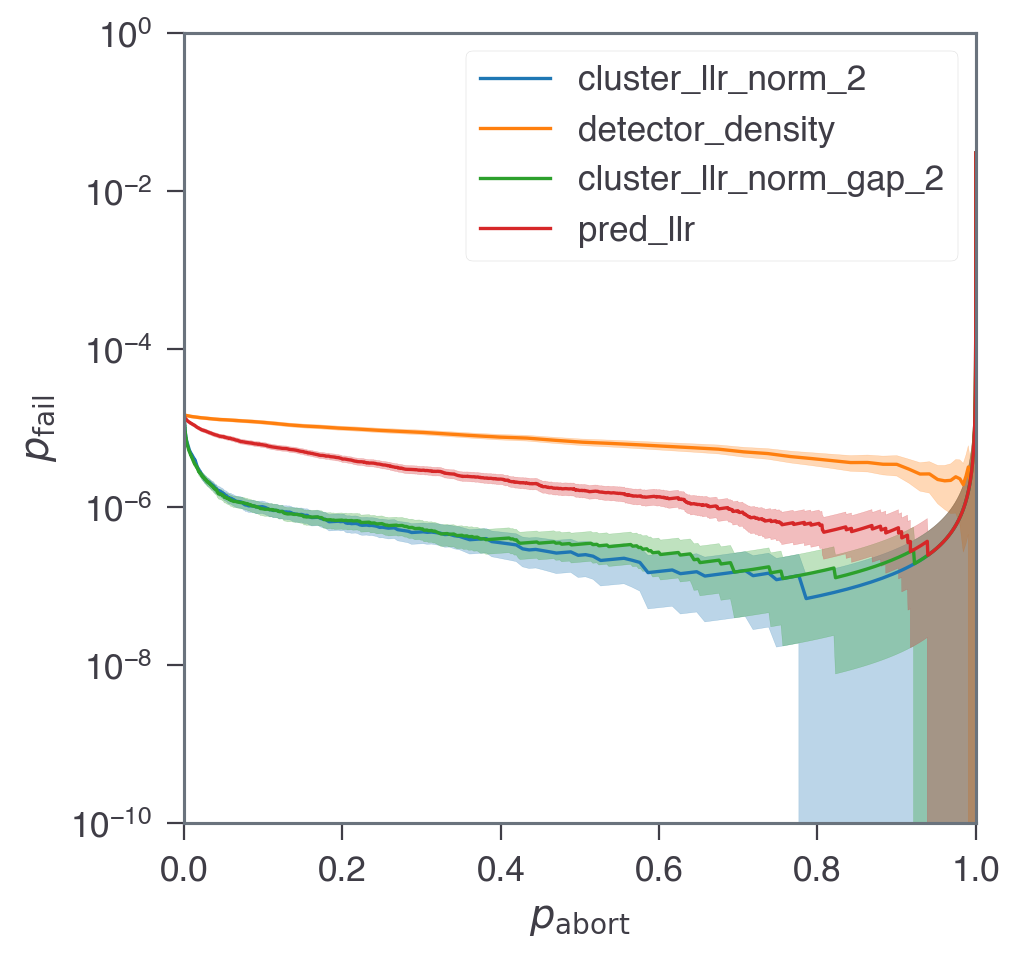

In [118]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 5))

d = T = 13
p = 0.015

i = 0
data_plots = {}
for by in df_ps_dict_phenom.keys():
    df_ps_all = df_ps_dict_phenom[by]
    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    try:
        df_ps = df_ps_all.loc[idx[d, T, p, :], :]
    except KeyError:
        continue

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values / T
    delta_p_fail = df_ps[delta_p_fail_col].values / T
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i % 10),
        linestyle="-" if i < 10 else "--",
        label=by,
        ax=ax,
    )
    i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()